In [1]:
# Import utils
import sys
import os
sys.path.append(os.path.dirname(os.path.realpath('__file__'))+'/utils')
from versions import version_0, version_1, version_2
from engine import con
from aggregate import aggregate_sql, create_aggregate

# Import packages
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

In [2]:
print(f'''
(0) current version: {version_0}
(1) previous version: {version_1}
(2) previous before previous version: {version_2}
''')


(0) current version: dcp_pluto."20v1"
(1) previous version: dcp_pluto."19v2"
(2) previous before previous version: dcp_pluto."19v1"



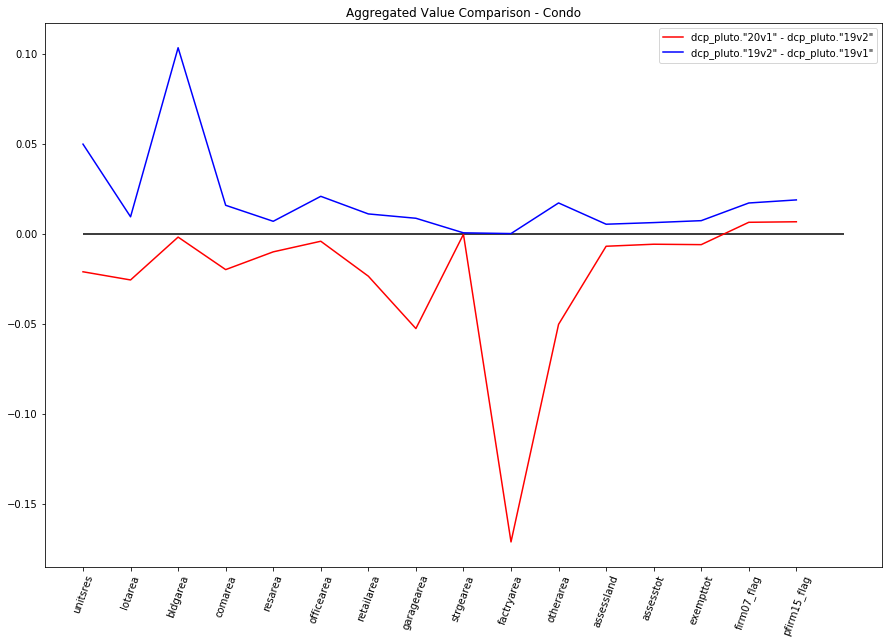

In [3]:
condition="WHERE right(bbl, 4) LIKE '75%%'"
create_aggregate(version_0, version_1, version_2, condition, con, aggregate_sql, 'Aggregated Value Comparison - Condo')

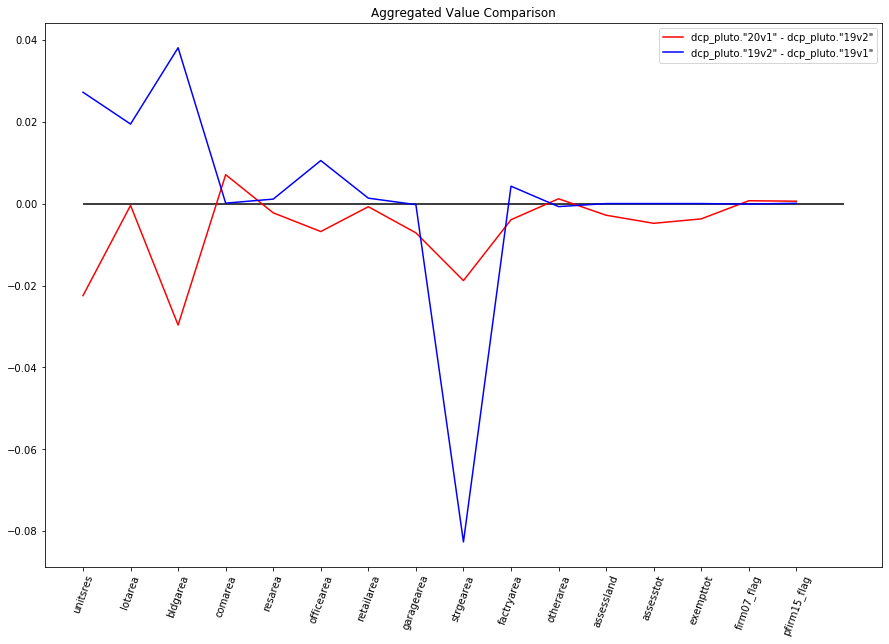

In [4]:
condition=''
create_aggregate(version_0, version_1, version_2, condition, con, aggregate_sql, 'Aggregated Value Comparison')